In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys
import urllib
from urllib import request
import zipfile
import pylab as pl
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Reading in inspection results
url = 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD'
df_insp = pd.read_csv(url)
# Reading in 311 results 
# Uploaded onto Github; the data contains only food poison complainsa as of December 12th, 2018
url_311 = 'https://github.com/sz2404/PUI2018_sz2404/blob/master/Extra_Credit_Project/311_Service_Requests_from_2010_to_Present.csv?raw=true'
df_311 = pd.read_csv(url_311)

In [4]:
# Downlouding PLUTO Data
url_pluto='https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v1.zip'
urllib.request.urlretrieve(url_pluto, os.getenv('PUIDATA') + '/nyc_pluto_18v1.zip')
zip_obj = zipfile.ZipFile(os.getenv('PUIDATA') + '/nyc_pluto_18v1.zip', 'r')
zip_obj.extractall(os.getenv('PUIDATA') + '/Pluto_all')

In [5]:
# Reading in all 5 boroughs and combine them together
MN = pd.read_csv(os.getenv('PUIDATA') + '/Pluto_all' + '/PLUTO_for_WEB' + '/MN_18v1.csv')
BK = pd.read_csv(os.getenv('PUIDATA') + '/Pluto_all' + '/PLUTO_for_WEB' + '/BK_18v1.csv')
BX = pd.read_csv(os.getenv('PUIDATA') + '/Pluto_all' + '/PLUTO_for_WEB' + '/BX_18v1.csv')
QN = pd.read_csv(os.getenv('PUIDATA') + '/Pluto_all' + '/PLUTO_for_WEB' + '/QN_18v1.csv')
SI = pd.read_csv(os.getenv('PUIDATA') + '/Pluto_all' + '/PLUTO_for_WEB' + '/SI_18v1.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,23,24,26,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/

In [6]:
# Combining the data of 5 boroughs into one. 
pluto = pd.concat([MN, BK, BX, QN, SI], ignore_index=True).reset_index()

In [7]:
pluto.Borough.nunique()

5

In [8]:
# Cleaning pluto df
pluto.columns

Index(['index', 'APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand',
       'AssessTot', 'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront',
       'Block', 'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD',
       'CT2010', 'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum',
       'Easements', 'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLAG',
       'FIRM07_Flag', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HealthCenterDistrict', 'HistDist', 'IrrLotCode',
       'LandUse', 'Landmark', 'Lot', 'LotArea', 'LotDepth', 'LotFront',
       'LotType', 'LtdHeight', 'NumBldgs', 'NumFloors', 'OfficeArea',
       'OtherArea', 'Overlay1', 'Overlay2', 'OwnerName', 'OwnerType',
       'PFIRM15_FLAG', 'PFIRM15_Flag', 'PLUTOMapID', 'PolicePrct', 'ProxCode',
       'ResArea', 'ResidFAR', 'RetailArea', 'SPDist1', 'SPDist2', 'SPDist3',
       'Sanborn', 'SanitBoro', 'SanitDistrict', 'SanitSub', 'SchoolDist',
       'SplitZone', 'StrgeArea', 'Tax

In [9]:
pluto = pluto.drop(['index', 'APPBBL', 'APPDate', 'AreaSource', 'AssessLand',
       'AssessTot', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront',
       'Block', 'BoroCode',  'BsmtCode', 'BuiltFAR', 'CB2010', 'CD',
       'CT2010', 'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum',
       'Easements', 'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLAG',
       'FIRM07_Flag', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HealthCenterDistrict', 'HistDist', 'IrrLotCode',
       'LandUse', 'Landmark', 'Lot', 'LotArea', 'LotDepth', 'LotFront',
       'LotType', 'LtdHeight', 'NumBldgs', 'NumFloors', 'OfficeArea',
       'OtherArea', 'Overlay1', 'Overlay2', 'OwnerName', 'OwnerType',
       'PFIRM15_FLAG', 'PFIRM15_Flag', 'PLUTOMapID', 'PolicePrct', 'ProxCode',
       'ResArea', 'ResidFAR', 'RetailArea', 'SPDist1', 'SPDist2', 'SPDist3',
       'Sanborn', 'SanitBoro', 'SanitDistrict', 'SanitSub', 'SchoolDist',
       'SplitZone', 'StrgeArea', 'TaxMap', 'Tract2010', 'UnitsRes',
       'UnitsTotal', 'Version', 'XCoord', 'YCoord', 'YearAlter1', 'YearAlter2',
       'YearBuilt', 'ZMCode',  'ZoneDist1', 'ZoneDist2', 'ZoneDist3',
       'ZoneDist4', 'ZoneMap'], axis=1)

## Cleaning Inspection sheet

In [10]:
df_insp.head(2)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,50058287,KIKU SUSHI,MANHATTAN,235,9TH AVE,10001.0,2126273660,Japanese,11/01/2018,Establishment Closed by DOHMH. Violations wer...,04L,Evidence of mice or live mice present in facil...,Critical,60.0,NaN,NaN,12/13/2018,Cycle Inspection / Initial Inspection
1,50084762,SMOOTHIE REY,MANHATTAN,1453,AMSTERDAM AVE,10027.0,3473733485,"Juice, Smoothies, Fruit Salads",11/19/2018,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,24.0,Not Yet Graded,NaN,12/13/2018,Cycle Inspection / Initial Inspection


In [11]:
df_insp['VIOLATION CODE'].unique()

array(['04L', '02G', '06D', '10F', '09C', '08A', '10J', '04A', '10B',
       '04H', '06C', '10A', '02B', '16B', '04M', nan, '10D', '02H', '05D',
       '06A', '08C', '10I', '06F', '16C', '08B', '10E', '20F', '10H',
       '06E', '04C', '05H', '04N', '22C', '06B', '18G', '04K', '04E',
       '16D', '10C', '09B', '15L', '04J', '04O', '09A', '02I', '22A',
       '20A', '16A', '05E', '22F', '05F', '15F', '20E', '02A', '04D',
       '16E', '02C', '15T', '03A', '03C', '20D', '03D', '05C', '10G',
       '18D', '22E', '07A', '15I', '22B', '18F', '18C', '05B', '06G',
       '03B', '05A', '02D', '15S', '04F', '15E', '02J', '20B', '22G',
       '03E', '15K', '15J', '02F', '04B', '15A', '06H', '03G', '16F',
       '03F', '04G', '18B', '19A', '02E', '06I', '15G', '04I', '17A'],
      dtype=object)

In [12]:
df_insp.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],
      dtype='object')

In [13]:
df_insp = df_insp.drop(['CUISINE DESCRIPTION', 'ACTION', 'GRADE',
       'GRADE DATE', 'RECORD DATE'], axis=1)

In [14]:
df_insp.head(2)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,INSPECTION DATE,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,INSPECTION TYPE
0,50058287,KIKU SUSHI,MANHATTAN,235,9TH AVE,10001.0,2126273660,11/01/2018,04L,Evidence of mice or live mice present in facil...,Critical,60.0,Cycle Inspection / Initial Inspection
1,50084762,SMOOTHIE REY,MANHATTAN,1453,AMSTERDAM AVE,10027.0,3473733485,11/19/2018,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,24.0,Cycle Inspection / Initial Inspection


In [15]:
# Converting the address to number + street name format
df_insp['ADDRESS'] = df_insp['BUILDING'] + " " + df_insp['STREET']

In [16]:
df_insp.head(3)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,INSPECTION DATE,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,INSPECTION TYPE,ADDRESS
0,50058287,KIKU SUSHI,MANHATTAN,235,9TH AVE,10001.0,2126273660,11/01/2018,04L,Evidence of mice or live mice present in facil...,Critical,60.0,Cycle Inspection / Initial Inspection,235 9TH AVE
1,50084762,SMOOTHIE REY,MANHATTAN,1453,AMSTERDAM AVE,10027.0,3473733485,11/19/2018,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,24.0,Cycle Inspection / Initial Inspection,1453 AMSTERDAM AVE
2,40576403,MAYA,MANHATTAN,1191,1 AVENUE,10065.0,2125851818,11/21/2018,06D,"Food contact surface not properly washed, rins...",Critical,23.0,Cycle Inspection / Initial Inspection,1191 1 AVENUE


In [17]:
# Seperating violation results
df_insp['Food_Protect'] = df_insp['VIOLATION CODE'].str.contains('02|04')
df_insp['Food_Source'] = df_insp['VIOLATION CODE'].str.contains('03')
df_insp['Food_Prep'] = df_insp['VIOLATION CODE'].str.contains('06')
df_insp['Facility_DM'] = df_insp['VIOLATION CODE'].str.contains('05|10')
df_insp['Vermin_Waste'] = df_insp['VIOLATION CODE'].str.contains('08')

In [18]:
df_insp.head(3)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,INSPECTION DATE,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,INSPECTION TYPE,ADDRESS,Food_Protect,Food_Source,Food_Prep,Facility_DM,Vermin_Waste
0,50058287,KIKU SUSHI,MANHATTAN,235,9TH AVE,10001.0,2126273660,11/01/2018,04L,Evidence of mice or live mice present in facil...,Critical,60.0,Cycle Inspection / Initial Inspection,235 9TH AVE,True,False,False,False,False
1,50084762,SMOOTHIE REY,MANHATTAN,1453,AMSTERDAM AVE,10027.0,3473733485,11/19/2018,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,24.0,Cycle Inspection / Initial Inspection,1453 AMSTERDAM AVE,True,False,False,False,False
2,40576403,MAYA,MANHATTAN,1191,1 AVENUE,10065.0,2125851818,11/21/2018,06D,"Food contact surface not properly washed, rins...",Critical,23.0,Cycle Inspection / Initial Inspection,1191 1 AVENUE,False,False,True,False,False


In [19]:
df_insp_cl = df_insp.drop(['CAMIS', 'BUILDING','STREET'], axis=1)

In [20]:
df_insp_add = df_insp_cl.sort_values(by=['ADDRESS'])

In [21]:
# Combining the result for each restaurant, i.e. all violations in one row
df_insp_com = df_insp_add.groupby('ADDRESS')["Food_Protect", "Food_Source", "Food_Prep", "Facility_DM","Vermin_Waste"].sum().reset_index()
df_insp_com.head(3)

,ADDRESS,Food_Protect,Food_Source,Food_Prep,Facility_DM,Vermin_Waste
0,.1-A EAST 77 ST,5,0,1,0,3
1,0 & GRAND CENTRAL,5,0,1,7,3
2,0 106 STREET & 5 AVENUE,7,0,4,7,2


In [22]:
df_insp_com.Food_Protect.unique()

array([5, 7, 0, 1, 4, 8, 2, 3, 11, 10, 24, 14, 61, 22, 9, 25, 70, 44, nan,
       38, 13, 12, 34, 17, 16, 6, 37, 33, 15, 20, 26, 18, 31, 30, 23, 21,
       19, 28, 35, 68, 27, 108, 169, 29, 39, 41, 36, 91, 32, 42, 59, 47,
       48, 123, 40, 43, 53, 46, 148], dtype=object)

In [23]:
# Fill in 0 for Nan as it means no violation detected.
df_insp_com.Food_Protect = df_insp_com.Food_Protect.fillna(0)
df_insp_com.Food_Source = df_insp_com.Food_Source.fillna(0)
df_insp_com.Food_Prep = df_insp_com.Food_Prep.fillna(0)
df_insp_com.Facility_DM = df_insp_com.Facility_DM.fillna(0)
df_insp_com.Vermin_Waste = df_insp_com.Vermin_Waste.fillna(0)

## Merge Inspection result with PLUTO to obtain the BBL for each restaurant 

In [24]:
df_insp_bbl = pd.merge(df_insp_com, pluto, left_on='ADDRESS', right_on='Address')
df_insp_bbl.head()

,ADDRESS,Food_Protect,Food_Source,Food_Prep,Facility_DM,Vermin_Waste,Address,BBL,Borough,ZipCode
0,1 5 AVENUE,8,0,2,3,3,1 5 AVENUE,1005500022,MN,10003.0
1,1 BLEECKER STREET,3,0,5,5,2,1 BLEECKER STREET,1005297505,MN,10012.0
2,1 BOUCK COURT,1,0,1,3,0,1 BOUCK COURT,3071920065,BK,11223.0
3,1 CENTRAL PARK WEST,1,0,1,4,1,1 CENTRAL PARK WEST,1011137502,MN,10023.0
4,1 CORSON AVENUE,3,0,5,9,3,1 CORSON AVENUE,5000180065,SI,10301.0


## Cleaning 311 DATA

In [25]:
df_311.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [26]:
df_311 = df_311.drop(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
        'Descriptor', 'Location Type', 
        'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'], axis=1)

In [27]:
df_311.head()

,Complaint Type,Incident Zip,Incident Address,BBL,Borough
0,Food Poisoning,10029.0,112 EAST 116 STREET,1.016430e+09,MANHATTAN
1,Food Poisoning,10469.0,NaN,NaN,BRONX
2,Food Poisoning,11430.0,JFK INTERNATIONAL AIRPORT,NaN,QUEENS
3,Food Poisoning,10305.0,41 REID AVENUE,5.032430e+09,STATEN ISLAND
4,Food Poisoning,10461.0,NaN,NaN,BRONX


In [28]:
df_311['Count'] = True
df_311_1 = df_311.groupby('BBL')['Count'].sum().reset_index()

## Merging all

In [29]:
df_all = pd.merge(df_311_1, df_insp_bbl, on='BBL', how='outer')
df_all.head()

,BBL,Count,ADDRESS,Food_Protect,Food_Source,Food_Prep,Facility_DM,Vermin_Waste,Address,Borough,ZipCode
0,3.075760e+05,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.000010e+09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.000020e+09,2.0,4 SOUTH STREET,36,1,16,18,13,4 SOUTH STREET,MN,10004.0
3,1.000030e+09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.000048e+09,3.0,1 WATER STREET,1,0,4,5,1,1 WATER STREET,MN,10004.0


In [30]:
df_all['Count'].unique()

array([ 1.,  2.,  3.,  5.,  4.,  9., 18.,  6.,  7., 24.,  8., 10., 12.,
       14., 11., 80., 33., 19., 15., 13., 27., 20., 21., 16., 17., 26.,
       nan])

In [32]:
# Fill nan with 0 because if no food poisoning cases were counted then treat as no case.
df_all['Count'] = df_all['Count'].fillna(0)

In [33]:
df_all['Incident'] = df_all['Count'].apply(lambda x: x>0)

In [34]:
df_all_select = df_all[["Food_Protect", "Food_Source", "Food_Prep", 
                        'Facility_DM', 'Vermin_Waste', 'Incident']].dropna()
df_all_short = df_all_select[["Food_Protect", "Food_Source", "Food_Prep", 'Facility_DM', 'Vermin_Waste']]

## Decision Tree & Random Forest Analysis

In [35]:
# Decision Tree
tree_reg =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", 
                                        random_state=222).fit(df_all_short.values, df_all_select["Incident"])
tree_reg.score(df_all_short.values, df_all_select["Incident"])

0.6271288318974153

In [36]:
tree_reg1 =  tree.DecisionTreeClassifier(max_depth=4, criterion="gini", 
                                        random_state=222).fit(df_all_short.values, df_all_select["Incident"])
tree_reg1.score(df_all_short.values, df_all_select["Incident"])

0.6279302744940893

In [37]:
# Random Forest
clf3 = ensemble.RandomForestClassifier(max_depth=3, criterion="gini", 
                                       random_state=222).fit(df_all_short.values, df_all_select["Incident"])
clf3.score(df_all_short.values, df_all_select["Incident"])

0.6271288318974153

In [38]:
clf4 = ensemble.RandomForestClassifier(max_depth=4, criterion="gini", 
                                       random_state=222).fit(df_all_short.values, df_all_select["Incident"])
clf4.score(df_all_short.values, df_all_select["Incident"])

0.6303346022841114

In [39]:
clf5 = ensemble.RandomForestClassifier(max_depth=5, criterion="gini", 
                                       random_state=222).fit(df_all_short.values, df_all_select["Incident"])
clf5.score(df_all_short.values, df_all_select["Incident"])

0.636145061109998

In [40]:
rforest_3 = clf3.fit(df_all_short.values, df_all_select["Incident"])
estimator9 = rforest_3.estimators_[9]
estimator5 = rforest_3.estimators_[5]
estimator3 = rforest_3.estimators_[3]
estimator1 = rforest_3.estimators_[1]

In [41]:
# Confusion matrix
X_train, X_test, y_train, y_test = train_test_split(df_all_short.values, 
    df_all_select["Incident"], test_size=0.33, random_state=42)

array([[976,  15],
       [638,  19]])

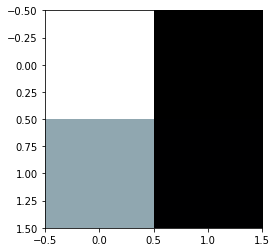

In [42]:
clf_3 = rfc(max_depth=3)
clf_3.fit(X_train, y_train)
y_pred = clf_3.predict(X_test)
imshow(confusion_matrix(y_test, y_pred), cmap='bone')
confusion_matrix(y_test, y_pred)
#True positive, False positive
#False negative, True negetive

In [43]:
clf_3.score(X_test, y_test)

0.6037621359223301

In [44]:
clf_3.score(X_train, y_train)

0.6398444510918336

array([[969,  22],
       [636,  21]])

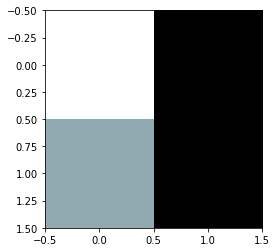

In [45]:
clf_4 = rfc(max_depth=4)
clf_4.fit(X_train, y_train)
y_pred = clf_4.predict(X_test)
imshow(confusion_matrix(y_test, y_pred), cmap='bone')
confusion_matrix(y_test, y_pred)

In [46]:
clf_4.score(X_test, y_test), clf_4.score(X_train, y_train)

(0.6007281553398058, 0.6425366437331738)

In [47]:
# Train test interpretations
# https://datascience.stackexchange.com/questions/28426/train-accuracy-vs-test-accuracy-vs-confusion-matrix

### Graph export

In [51]:
# Tree from random forest
from sklearn.tree import export_graphviz
export_graphviz(estimator5, out_file='tree_rf_5.dot', 
                rounded = True, proportion = False, filled = True)
export_graphviz(estimator1, out_file='tree_rf_1.dot', 
                rounded = True, proportion = False, filled = True)

In [50]:
# Tree from Decision Tree
from sklearn.tree import export_graphviz
from sklearn.datasets import load_iris
tree.export_graphviz(tree_reg, out_file='tree_b.dot')   
tree.export_graphviz(tree_reg1, out_file='tree_1b.dot')  

In [16]:
# https://gist.github.com/milesgrimshaw/5b1cee4e2b6acb1c215f
# http://milesgrimshaw.com/nyc-restaurant-database/

In [1]:
# Tree Visualization
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
# https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

In [ ]:
# https://stackoverflow.com/questions/27975069/how-to-filter-rows-containing-a-string-pattern-from-a-pandas-dataframe